<a href="https://colab.research.google.com/github/diefgallegorio/Estadistica2/blob/main/ProyectoEII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

#Librerías para acceder a archivos desde google drive en google colaboratory 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Importo base de datos de los resutados de las pruebas saber pro 2019
icfes = '12KFWoUTAoHUPxmL2nYDlvPXcf2KBWwCA'
downloaded = drive.CreateFile({'id': icfes})
downloaded.GetContentFile('Icfes_pro_genericas.csv') 

#Leo la base de datos y pruebo que cargue adecuadamente en Pandas
Xdata = pd.read_csv('Icfes_pro_genericas.csv')

In [ ]:
#Exploramos con qué datos contamos, para saber cuáles se pueden incluir en la regresión (Datos cuantitativos o que se puedan convertir en ello)
Xdata.reset_index(inplace=True,drop=True)
Xdata.head()

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_DISC_FISICA,ESTU_DISC_SISTEM,ESTU_DISC_AUDITCASTELL,ESTU_DISC_AUDITLSC,ESTU_DISC_VISUALCEGUE,ESTU_DISC_VISUALBAJA,ESTU_DISC_VOZHABLA,ESTU_DISC_INTELEC,ESTU_DISC_SORDOCEGUERA,ESTU_DISC_PSICOSOCIAL,ESTU_DISC_ASPERGER,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,ESTU_AREARESIDE,ESTU_COLE_TERMINO,ESTU_OTROCOLE_TERMINO,ESTU_CODDANE_COLE_TERMINO,ESTU_COD_COLE_MCPIO_TERMINO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_COMOCAPACITOEXAMENSB11,ESTU_CURSODOCENTESIES,ESTU_CURSOIESAPOYOEXTERNO,ESTU_CURSOIESEXTERNA,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_NUCLEO_PREGRADO,ESTU_INST_CODMUNICIPIO,ESTU_INST_MUNICIPIO,ESTU_INST_DEPARTAMENTO,INST_CARACTER_ACADEMICO,INST_ORIGEN,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,MOD_RAZONA_CUANTITAT_PUNT,MOD_RAZONA_CUANTITAT_DESEM,MOD_RAZONA_CUANTITATIVO_PNAL,MOD_RAZONA_CUANTITATIVO_PNBC,MOD_LECTURA_CRITICA_PUNT,MOD_LECTURA_CRITICA_DESEM,MOD_LECTURA_CRITICA_PNAL,MOD_LECTURA_CRITICA_PNBC,MOD_COMPETEN_CIUDADA_PUNT,MOD_COMPETEN_CIUDADA_DESEM,MOD_COMPETEN_CIUDADA_PNAL,MOD_COMPETEN_CIUDADA_PNBC,MOD_INGLES_PUNT,MOD_INGLES_DESEM,MOD_INGLES_PNAL,MOD_INGLES_PNBC,MOD_COMUNI_ESCRITA_PUNT,MOD_COMUNI_ESCRITA_DESEM,MOD_COMUNI_ESCRITA_PNAL,MOD_COMUNI_ESCRITA_PNBC,PUNT_GLOBAL,PERCENTIL_NBC,PERCENTIL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_IES,ESTU_ESTADOINVESTIGACION
0,CC,COLOMBIA,F,06/08/1996 12:00:00 AM,NO,20195,EK201950332829,ESTUDIANTE,COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VALLE,76.0,CALI,76001.0,Cabecera Municipal,24611.0,NaN,1.760010e+11,76001.0,Entre 2.5 millones y menos de 4 millones,No,No,No,Si,Tomó un curso de preparación,Entre 20 y 30 horas,Entre 20 y 30 horas,Entre 20 y 30 horas,Si,Si,...,UNIVERSITARIO,PRESENCIAL,ADMINISTRACIÓN,76001,CALI,VALLE,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,N,76001,CALI,VALLE,76,105,1,11.0,12.0,111,1,12.0,17.0,100,1,12.0,14.0,111.0,-A1,9.0,10.0,106.0,1.0,6.0,6.0,107,4.0,4.0,44.926713,1.0,3,PUBLICAR
1,CC,COLOMBIA,F,02/01/1999 12:00:00 AM,NO,20195,EK201950328090,ESTUDIANTE,COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VALLE,76.0,CALI,76001.0,Cabecera Municipal,19823.0,NaN,1.760010e+11,76001.0,Entre 2.5 millones y menos de 4 millones,No,Si,No,Si,Repasó por cuenta propia,NaN,NaN,NaN,NaN,NaN,...,UNIVERSITARIO,PRESENCIAL,ADMINISTRACIÓN,76001,CALI,VALLE,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,N,76001,CALI,VALLE,76,130,2,33.0,38.0,137,2,37.0,48.0,171,3,80.0,88.0,140.0,A1,38.0,46.0,143.0,2.0,50.0,53.0,144,59.0,48.0,66.702352,4.0,3,PUBLICAR
2,CC,COLOMBIA,F,12/13/1984 12:00:00 AM,NO,20195,EK201950332409,ESTUDIANTE,COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VALLE,76.0,CALI,76001.0,Cabecera Municipal,0.0,NaN,NaN,NaN,Entre 2.5 millones y menos de 4 millones,No,No,No,Si,Repasó por cuenta propia,NaN,NaN,NaN,NaN,NaN,...,UNIVERSITARIO,PRESENCIAL,ADMINISTRACIÓN,76001,CALI,VALLE,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,N,76001,CALI,VALLE,76,135,2,37.0,44.0,141,2,41.0,53.0,135,2,42.0,50.0,143.0,A1,42.0,50.0,175.0,3.0,84.0,87.0,146,62.0,51.0,57.585745,3.0,3,PUBLICAR
3,CC,COLOMBIA,F,08/09/1990 12:00:00 AM,NO,20195,EK201950332743,ESTUDIANTE,COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VALLE,76.0,CANDELARIA,76130.0,Area Rural,3642.0,NaN,2.761300e+11,76130.0,Entre 2.5 millones y menos de 4 millones,No,Si,Si,Si,Tomó un curso de preparación,Menos de 20 horas,Menos de 20 horas,Menos de 20 horas,Si,Si,...,UNIVERSITARIO,PRESENCIAL,ADMINISTRACIÓN,76001,CALI,VALLE,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,N,76001,CALI,VALLE,76,120,1,22.0,26.0,110,1,12.0,15.0,154,2,62.0,72.0,122.0,-A1,16.0,19.0,145.0,2.0,55.0,

In [ ]:
#Reuno las variables cuantitativas o que se pueden convertir en ello.
Xdata=Xdata.loc[:,['ESTU_VALORMATRICULAUNIVERSIDAD','ESTU_CURSODOCENTESIES','ESTU_CURSOIESAPOYOEXTERNO','ESTU_CURSOIESEXTERNA',
                   'ESTU_SEMESTRECURSA', 'FAMI_ESTRATOVIVIENDA','ESTU_HORASSEMANATRABAJA', 'MOD_COMPETEN_CIUDADA_PUNT',
                   'MOD_RAZONA_CUANTITAT_PUNT','MOD_LECTURA_CRITICA_PUNT','MOD_INGLES_PUNT','MOD_COMUNI_ESCRITA_PUNT','PUNT_GLOBAL']]

#Con los datos reunidos, cuento cuántos valores nulos tiene cada columna, para decidir si se eliminan o se dejan para la regresión.
Xdata.isnull().sum().sort_values(ascending=False).head(25)

ESTU_CURSOIESEXTERNA              230206
ESTU_CURSOIESAPOYOEXTERNO         230197
ESTU_CURSODOCENTESIES             230174
FAMI_ESTRATOVIVIENDA               16367
ESTU_HORASSEMANATRABAJA            12916
ESTU_SEMESTRECURSA                  4263
ESTU_VALORMATRICULAUNIVERSIDAD      4263
MOD_COMUNI_ESCRITA_PUNT              310
MOD_INGLES_PUNT                       71
PUNT_GLOBAL                            0
MOD_LECTURA_CRITICA_PUNT               0
MOD_RAZONA_CUANTITAT_PUNT              0
MOD_COMPETEN_CIUDADA_PUNT              0
dtype: int64

In [ ]:
#Se eliminan las variables que cuentan con un elevado número de valores nulos, pues si se incluyen aportarán demasiado sesgo a la regresión
Xdata.drop(columns=['ESTU_CURSOIESEXTERNA','ESTU_CURSOIESAPOYOEXTERNO','ESTU_CURSODOCENTESIES'], inplace=True)

#Se observa de nuevo cómo está el conjunto de datos ya con las columnas necesarias, para identificar cómo  convertir algunos valores cualitativos en cuantitativos
Xdata.head()


,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_SEMESTRECURSA,FAMI_ESTRATOVIVIENDA,ESTU_HORASSEMANATRABAJA,MOD_COMPETEN_CIUDADA_PUNT,MOD_RAZONA_CUANTITAT_PUNT,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMUNI_ESCRITA_PUNT,PUNT_GLOBAL
0,Entre 2.5 millones y menos de 4 millones,09,Estrato 1,Menos de 10 horas,100,105,111,111.0,106.0,107
1,Entre 2.5 millones y menos de 4 millones,08,Estrato 3,Entre 21 y 30 horas,171,130,137,140.0,143.0,144
2,Entre 2.5 millones y menos de 4 millones,08,Estrato 3,Más de 30 horas,135,135,141,143.0,175.0,146
3,Entre 2.5 millones y menos de 4 millones,09,Estrato 2,Más de 30 horas,154,120,110,122.0,145.0,130
4,Entre 2.5 millones y menos de 4 millones,09,Estrato 3,0,147,142,153,162.0,0.0,121


In [ ]:
#Para las variables actualmente cualitativas, las convierto en cuantitativas
VLR_MAT = ['No pagó matrícula','Menos de 500 mil','Entre 500 mil y menos de 1 millón',
           'Entre 1 millón y menos de 2.5 millones','Entre 2.5 millones y menos de 4 millones',
           'Entre 4 millones y menos de 5.5 millones','Entre 5.5 millones y menos de 7 millones','Más de 7 millones']
SEM_CUR = ['1','2','3','4','5','6','7','8','9','10','11','12 o más']
EST_VIV = ['Sin Estrato','Estrato 1','Estrato 2','Estrato 3','Estrato 4','Estrato 5','Estrato 6']
HOR_TRA = ['0','Menos de 10 horas','Entre 11 y 20 horas','Entre 21 y 30 horas','Más de 30 horas']

#Separo cada una de las conversiones, ya que tienen escalas diferentes
a=b=c=d=0
for i in VLR_MAT:
  Xdata['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(i,a,inplace=True)
  a+=1
for i in SEM_CUR:
  Xdata['ESTU_SEMESTRECURSA'].replace(i,b,inplace=True)
  b+=1
for i in EST_VIV:
  Xdata['FAMI_ESTRATOVIVIENDA'].replace(i,c,inplace=True)
  c+=1
for i in HOR_TRA:
  Xdata['ESTU_HORASSEMANATRABAJA'].replace(i,d,inplace=True)
  d+=1
Xdata.describe()

,ESTU_VALORMATRICULAUNIVERSIDAD,FAMI_ESTRATOVIVIENDA,ESTU_HORASSEMANATRABAJA,MOD_COMPETEN_CIUDADA_PUNT,MOD_RAZONA_CUANTITAT_PUNT,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMUNI_ESCRITA_PUNT,PUNT_GLOBAL
count,256493.000000,244389.000000,247840.000000,260756.000000,260756.000000,260756.000000,260685.000000,260446.000000,260756.000000
mean,3.524732,2.562018,2.420824,142.488368,146.556382,149.034082,151.990805,143.755496,146.730365
std,1.748364,1.134810,1.533530,33.341571,31.714098,31.376962,32.302377,37.540395,23.631071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,118.000000,123.000000,126.000000,131.000000,132.000000,130.000000
50%,3.000000,2.000000,3.000000,143.000000,146.000000,149.000000,149.000000,143.000000,145.000000
75%,5.000000,3.000000,4.000000,167.000000,168.000000,172.000000,173.000000,167.000000,162.000000
max,7.000000,6.000000,4.000000,300.000000,300.000000,300.000000,300.000000,300.000000,256.000000


In [ ]:
Xdata.corr(method="pearson")

,ESTU_VALORMATRICULAUNIVERSIDAD,FAMI_ESTRATOVIVIENDA,ESTU_HORASSEMANATRABAJA,MOD_COMPETEN_CIUDADA_PUNT,MOD_RAZONA_CUANTITAT_PUNT,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMUNI_ESCRITA_PUNT,PUNT_GLOBAL
ESTU_VALORMATRICULAUNIVERSIDAD,1.000000,0.398248,-0.100793,0.160565,0.141550,0.151051,0.303947,0.103969,0.239453
FAMI_ESTRATOVIVIENDA,0.398248,1.000000,-0.063597,0.193134,0.179017,0.194606,0.372801,0.094164,0.283085
ESTU_HORASSEMANATRABAJA,-0.100793,-0.063597,1.000000,-0.098984,-0.068265,-0.132542,-0.167179,-0.042397,-0.139212
MOD_COMPETEN_CIUDADA_PUNT,0.160565,0.193134,-0.098984,1.000000,0.444373,0.643704,0.501251,0.213907,0.777146
MOD_RAZONA_CUANTITAT_PUNT,0.141550,0.179017,-0.068265,0.444373,1.000000,0.528585,0.476822,0.173103,0.719370
MOD_LECTURA_CRITICA_PUNT,0.151051,0.194606,-0.132542,0.643704,0.528585,1.000000,0.521151,0.214430,0.799453
MOD_INGLES_PUNT,0.303947,0.372801,-0.167179,0.501251,0.476822,0.521151,1.000000,0.201416,0.744232
MOD_COMUNI_ESCRITA_PUNT,0.103969,0.094164,-0.042397,0.213907,0.173103,0.214430,0.201416,1.000000,0.536872
PUNT_GLOBAL,0.239453,0.283085,-0.139212,0.777146,0.719370,0.799453,0.744232,0.536872,1.000000


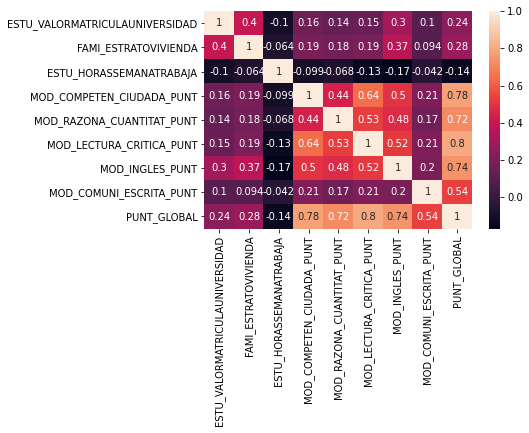

In [ ]:
#  Matriz de correlación
import seaborn as sns
correlation_mat = Xdata.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

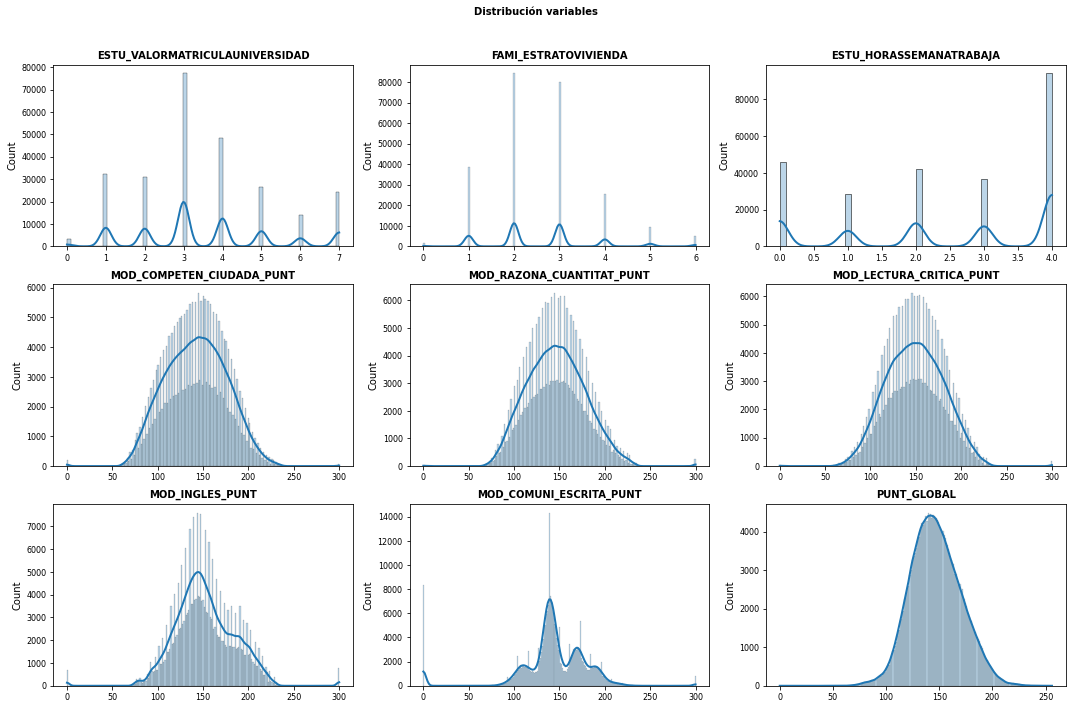

In [ ]:
# Gráfico de distribución para cada variable numérica
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flat
columnas_numeric = Xdata.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = Xdata,
        x       = colum,
        stat    = "count",
        kde     = True,
        # color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables', fontsize = 10, fontweight = "bold");

In [ ]:
#Prueba de regresión lineal simple
#Datos entrada: Puntaje módulo de competencia ciudadana ('MOD_COMPETEN_CIUDADA_PUNT')
#Datos salida: Puntaje global ('PUNT_GLOBAL')
data =Xdata[['MOD_COMPETEN_CIUDADA_PUNT']]
X_train = np.array(data)
y_train = Xdata['PUNT_GLOBAL'].values
 
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(X_train, y_train)
 
# Hacemos las predicciones 
y_pred = regr.predict(X_train)
 
# Coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

Coefficients: 
 [0.55080788]
Independent term: 
 68.24664929952496
Mean squared error: 221.16
Variance score: 0.60


De la ecuación de la recta y = mX + b nuestra pendiente “m” es el coeficiente 0,55 y el término independiente “b” es 68,24 Tenemos un Error Cuadrático medio de 221,16 y varianza de 0,60 

In [ ]:
# Vamos a comprobar:
# Quiero predecir cuánto puntaje global voy a obtener por con 60 puntos en el módulo de competencia ciudadana,
# según nuestro modelo, hacemos:
y_puntos = regr.predict([[60]])
print(int(y_puntos))

101


Nos devuelve una predicción de 101 puntos de PUNTAJE GLOBAL si se obtuvieran 60 puntos en el módulo de ocmpetencia ciudadana

# **Regresión Lineal Múltiple**
La ecuación pasa a ser: Y = b + m1 X1 + m2 X2 + … + m(n) X(n)

La primer entrada de nuestro modelo es el valor de la matrícula del estudiante ('ESTU_VALORMATRICULAUNIVERSIDAD'), la segunda es el semestre que cursa el estudiante ('ESTU_SEMESTRECURSA'), la tercer entrada es el estrato de la vivienda ('FAMI_ESTRATOVIVIENDA') y la cuarta es las horas que trabaja a la semana ('ESTU_HORASSEMANATRABAJA')


In [ ]:
# variables de entrada en XY_train y la variable de salida pasa de ser “Y” a ser el eje “Z”.

Xdata2 =  Xdata.loc[:,['ESTU_VALORMATRICULAUNIVERSIDAD','ESTU_SEMESTRECURSA','FAMI_ESTRATOVIVIENDA','ESTU_HORASSEMANATRABAJA']]
Xdata2['ESTU_SEMESTRECURSA']=pd.to_numeric(Xdata['ESTU_SEMESTRECURSA'],errors ='coerce')
#Imputando los valores NaN con la media 

for i in Xdata2.columns:
  Xdata2[i].fillna((Xdata2[i].mean()), inplace=True)

XY_train = np.array(Xdata2)
z_train = Xdata['PUNT_GLOBAL'].values

Creamos un nuevo objeto de Regresión lineal con SKLearn pero esta vez tendrá las cuatro dimensiones que entrenar: las que contiene XY_train. Al igual que antes, imprimimos los coeficientes y puntajes obtenidos:

In [ ]:
regr2 = linear_model.LinearRegression()
 
# Entrenamos el modelo, esta vez, con 2 dimensione
regr2.fit(XY_train, z_train)
 
# Hacemos la predicción 
z_pred = regr2.predict(XY_train)
 
# Los coeficientes
print('Coefficients: \n', regr2.coef_)
# Error cuadrático medio
print("Mean squared error: %.2f" % mean_squared_error(z_train, z_pred))
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(z_train, z_pred))

Coefficients: 
 [ 1.97852362  1.32404429  4.48081898 -1.70843824]
Mean squared error: 497.54
Independent term: 
 68.24664929952496
Variance score: 0.11


In [ ]:
# Para poner en práctica el ejercicio, queremos probarlo prediciendo el PUNTAJE GLOBAL de un estudiante con las siguientes características:
# Estudiante que tiene que paga una matrícula de Entre 500 mil y menos de 1 millón; cursa 10° semestre de su carrera profesional, 
# la vivienda es estrato 4 y trabaja Entre 11 y 20 horas.

z_ = regr2.predict([[3, 10, 4, 2]])
print(int(z_))

154
